# Imports and dataset load
First, we import some required packages, and load the dataset.

In [805]:
library(ggplot2)
library(psych)
library(repr)
library(gridExtra)
library(corrplot)
library(viridis)
library(mltools)
library(data.table)
library(caret)
library(Hmisc)

In [806]:
df <- read.csv(file = 'data/base_familia_2018.csv', header = TRUE, sep = ';', nrows = 100000)

In [807]:
# Get an overview of the dataset, and print the number of rows and columns
head(df)
nrow(df)
ncol(df)

,cd_ibge,estrato,classf,id_familia,dat_cadastramento_fam,dat_alteracao_fam,vlr_renda_media_fam,dat_atualizacao_familia,cod_local_domic_fam,cod_especie_domic_fam,⋯,cod_familia_indigena_fam,ind_familia_quilombola_fam,nom_estab_assist_saude_fam,cod_eas_fam,nom_centro_assist_fam,cod_centro_assist_fam,ind_parc_mds_fam,marc_pbf,qtde_pessoas,peso.fam
,<int>,<int>,<int>,<dbl>,<fct>,<fct>,<int>,<fct>,<int>,<int>,⋯,<int>,<int>,<fct>,<int>,<fct>,<dbl>,<int>,<int>,<int>,<dbl>
1,3205002,2,2,1,2018-06-28,2018-10-02,244,2018-06-28,1,1,⋯,2,2,,NA,CRAS DE SERRA SEDE,32050034575,0,0,5,5.502565e+14
2,3205101,2,2,3,2018-08-27,2018-11-29,60,2018-11-29,1,1,⋯,2,2,,NA,CRAS VIANA,32051030269,0,1,5,5.503557e+14
3,3201308,2,2,4,2018-02-23,2018-02-27,937,2018-02-23,1,1,⋯,2,2,,NA,CRAS IV ALTO MUCURI,32013002407,0,0,1,5.502597e+14
4,3201308,2,2,6,2013-12-27,2018-10-01,44,2017-06-22,1,1,⋯,2,2,US CAMPO VERDE,2652994,CRAS III CAMPO VERDE,32013002406,0,1,2,5.502597e+14
5,3205002,2,2,7,2018-03-26,2018-03-28,0,2018-03-26,1,1,⋯,2,2,UNIDADE REGIONAL DE SAUDE SERRA,2465795,,NA,0,1,2,5.502565e+14
6,3205002,2,2,8,2016-10-27,2018-10-01,176,2016-10-27,1,1,⋯,2,2,UNIDADE BASICA DE SAUDE VILA NOVA DE COLARES,2522845,CRAS DE VILA NOVA DE COLARES,32050002912,0,1,5,5.502565e+14


[1] 100000

[1] 31

# Pre-processing and data cleaning
We first get an overview of missing data, by displaying the number of NA entries in each column. In the sub-sequent cells, we rename some categorical variables, remove some columns and merge some categories.

In [808]:
data.frame(colSums(is.na(df)))

,colSums.is.na.df..
,<dbl>
cd_ibge,0
estrato,0
classf,0
id_familia,0
dat_cadastramento_fam,0
dat_alteracao_fam,0
vlr_renda_media_fam,6
dat_atualizacao_familia,0
cod_local_domic_fam,198


In [809]:
# Treat the 'cod_escoa_sanitario_domic_fam' column
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 1] <- 'Rede coletora'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 2] <- 'Fossa septica'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 3] <- 'Fossa rudimentar'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 4] <- 'Vala a ceu aberto'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 5] <- 'Rio, lago ou mar'

# Convert 'Outro' and 'NA' to 'others'
df$cod_escoa_sanitario_domic_fam[is.na(df$cod_escoa_sanitario_domic_fam)] <- 'Outro'
df$cod_escoa_sanitario_domic_fam[df$cod_escoa_sanitario_domic_fam == 6] <- 'Outro'

# Display 'cod_escoa_sanitario_domic_fam'
data.frame(table(df$cod_escoa_sanitario_domic_fam))

Var1,Freq
<fct>,<int>
Fossa rudimentar,34412
Fossa septica,17995
Outro,13866
Rede coletora,30191
"Rio, lago ou mar",808
Vala a ceu aberto,2728


In [810]:
# The 'ind_familia_quilombola_fam' column presents 'NA' for samples classified as indigena.
# As very few samples are marked as quilombola, we join it with indigena
df$ind_familia_quilombola_fam[is.na(df$ind_familia_quilombola_fam)] <- 1
names(df)[names(df) == 'ind_familia_quilombola_fam'] <- 'indigena_quilombola'

In [811]:
# Code convention: convert values with 2 (meaning no presence) to 0
df$cod_local_domic_fam[df$cod_local_domic_fam == 2] <- 0
df$cod_familia_indigena_fam[df$cod_familia_indigena_fam == 2] <- 0
df$cod_banheiro_domic_fam[df$cod_banheiro_domic_fam == 2] <- 0
df$cod_agua_canalizada_fam[df$cod_agua_canalizada_fam == 2] <- 0
df$indigena_quilombola[df$indigena_quilombola == 2] <- 0

# Code convention: convert Estrato values -- (1) Urban, (0) Rural
df$estrato[df$estrato == 1] <- 0
df$estrato[df$estrato == 2] <- 1

In [812]:
# Get uninformative columns or columns with many NA entries
drop <- c(
    'cd_ibge',
    'dat_cadastramento_fam',
    'dat_alteracao_fam',
    'dat_atualizacao_familia',
    'nom_estab_assist_saude_fam',
    'cod_eas_fam',
    'nom_centro_assist_fam',
    'cod_centro_assist_fam',
    'ind_parc_mds_fam',
    'peso.fam',
    'cod_familia_indigena_fam',
    'ind_familia_quilombola_fam'
)

# Remove columns
df <- df[, !(names(df) %in% drop)]

# We have some samples with NA entries. As for these samples the NAs occur in most columns and
# the number os samples with NA are not significant, we remove these rows
df <- na.omit(df)

In [813]:
# Treating 'cod_material_piso_fam'
df$cod_material_piso_fam[df$cod_material_piso_fam == 2] <- 'Cimento'
df$cod_material_piso_fam[df$cod_material_piso_fam == 5] <- 'Ceramica, lajota ou pedra'

# As the 'Madeira' class has few samples, we join 'Madeira aproveitada' and 'Madeira aparelhada'
df$cod_material_piso_fam[df$cod_material_piso_fam == 3] <- 'Madeira'
df$cod_material_piso_fam[df$cod_material_piso_fam == 4] <- 'Madeira'

# As 'Terra', 'Carpete', and 'Outro' has few samples, we agreggate them in 'Others'
df$cod_material_piso_fam[df$cod_material_piso_fam == 1] <- 'Outro'
df$cod_material_piso_fam[df$cod_material_piso_fam == 6] <- 'Outro'
df$cod_material_piso_fam[df$cod_material_piso_fam == 7] <- 'Outro'

# Display 'cod_material_piso_fam'
data.frame(table(df$cod_material_piso_fam))

Var1,Freq
<fct>,<int>
"Ceramica, lajota ou pedra",40935
Cimento,37785
Madeira,10723
Outro,4305


In [814]:
# Treating 'cod_material_domic_fam'
df$cod_material_domic_fam[df$cod_material_domic_fam == 1] <- 'Alvenaria (com revestimento)'
df$cod_material_domic_fam[df$cod_material_domic_fam == 2] <- 'Alvenaria (sem revestimento)'

# Joining 'Madeira aproveitada' and 'Madeira aparelhada'
df$cod_material_domic_fam[df$cod_material_domic_fam == 3] <- 'Madeira'
df$cod_material_domic_fam[df$cod_material_domic_fam == 6] <- 'Madeira'

# Joining 'Taipa revestida' and 'Taipa nao revestida'
df$cod_material_domic_fam[df$cod_material_domic_fam == 4] <- 'Taipa'
df$cod_material_domic_fam[df$cod_material_domic_fam == 5] <- 'Taipa'

# Joining 'Palha', and 'Outro'
df$cod_material_domic_fam[df$cod_material_domic_fam == 7] <- 'Outro'
df$cod_material_domic_fam[df$cod_material_domic_fam == 8] <- 'Outro'

# Display 'cod_material_domic_fam'
data.frame(table(df$cod_material_domic_fam))

Var1,Freq
<fct>,<int>
Alvenaria (com revestimento),53898
Alvenaria (sem revestimento),13357
Madeira,23226
Outro,901
Taipa,2366


In [815]:
# Treating 'cod_abaste_agua_domic_fam'
df$cod_abaste_agua_domic_fam[df$cod_abaste_agua_domic_fam == 1] <- 'Rede de distribuicao'
df$cod_abaste_agua_domic_fam[df$cod_abaste_agua_domic_fam == 2] <- 'Poco ou nascente'
df$cod_abaste_agua_domic_fam[df$cod_abaste_agua_domic_fam == 3] <- 'Cisterna'
df$cod_abaste_agua_domic_fam[df$cod_abaste_agua_domic_fam == 4] <- 'Outro'

# Display 'cod_abaste_agua_domic_fam'
data.frame(table(df$cod_abaste_agua_domic_fam))

Var1,Freq
<fct>,<int>
Cisterna,2735
Outro,3526
Poco ou nascente,25091
Rede de distribuicao,62396


In [816]:
# Display 'cod_especie_domic_fam'
data.frame(table(df$cod_especie_domic_fam))

# After removing the NA entries, the cod_especie_domic_fam column has only one value, so we remove it
df <- df[, !(names(df) %in% c('cod_especie_domic_fam'))]

Var1,Freq
<fct>,<int>
1,93748


In [817]:
# Treating 'cod_destino_lixo_domic_fam'
df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 1] <- 'Coletado'
df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 2] <- 'Coletado'

df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 3] <- 'Queimado ou enterrado'

df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 4] <- 'Jogado'
df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 5] <- 'Jogado'

df$cod_destino_lixo_domic_fam[df$cod_destino_lixo_domic_fam == 6] <- 'Outro'

# Display 'cod_destino_lixo_domic_fam'
data.frame(table(df$cod_destino_lixo_domic_fam))

Var1,Freq
<fct>,<int>
Coletado,73849
Jogado,936
Outro,421
Queimado ou enterrado,18542


In [818]:
# Treating 'cod_iluminacao_domic_fam'

# We join 'Eletrica com medidor proprio', 'Eletrica com medidor comunitario', and 'Eletrica sem medidor' in one class
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 1] <- 1
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 2] <- 1
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 3] <- 1

# We join 'Oleo/Querosene/Gas', 'Vela', and 'Outro' in one class
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 4] <- 0
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 5] <- 0
df$cod_iluminacao_domic_fam[df$cod_iluminacao_domic_fam == 6] <- 0

# Display 'cod_iluminacao_domic_fam', which is now a binary variable -- (0) no eletricity, (1) has eletricity
data.frame(table(df$cod_iluminacao_domic_fam))

Var1,Freq
<fct>,<int>
0,4606
1,89142


In [819]:
# Treating 'cod_calcamento_domic_fam'

# We join 'Parcial' and 'Total'
df$cod_calcamento_domic_fam[df$cod_calcamento_domic_fam == 2] <- 1

# And mark 'Nao existe' as 0
df$cod_calcamento_domic_fam[df$cod_calcamento_domic_fam == 3] <- 0

# Display 'cod_calcamento_domic_fam', which is now a binary variable -- (0) no calcamento, (1) has calcamento
data.frame(table(df$cod_calcamento_domic_fam))

Var1,Freq
<fct>,<int>
0,41001
1,52747


In [820]:
# Define a customized theme to be shared by our plots
mytheme <- theme(text = element_text(size = 20))

# Income anaysis
In this section, we present some preliminary analysis regarding the families income. In the first analysis below, we devide the income into intervals, and present the average income (per capita) distribution of three groups: overall population, families not registered in the BF program, and families registered in the BF program.

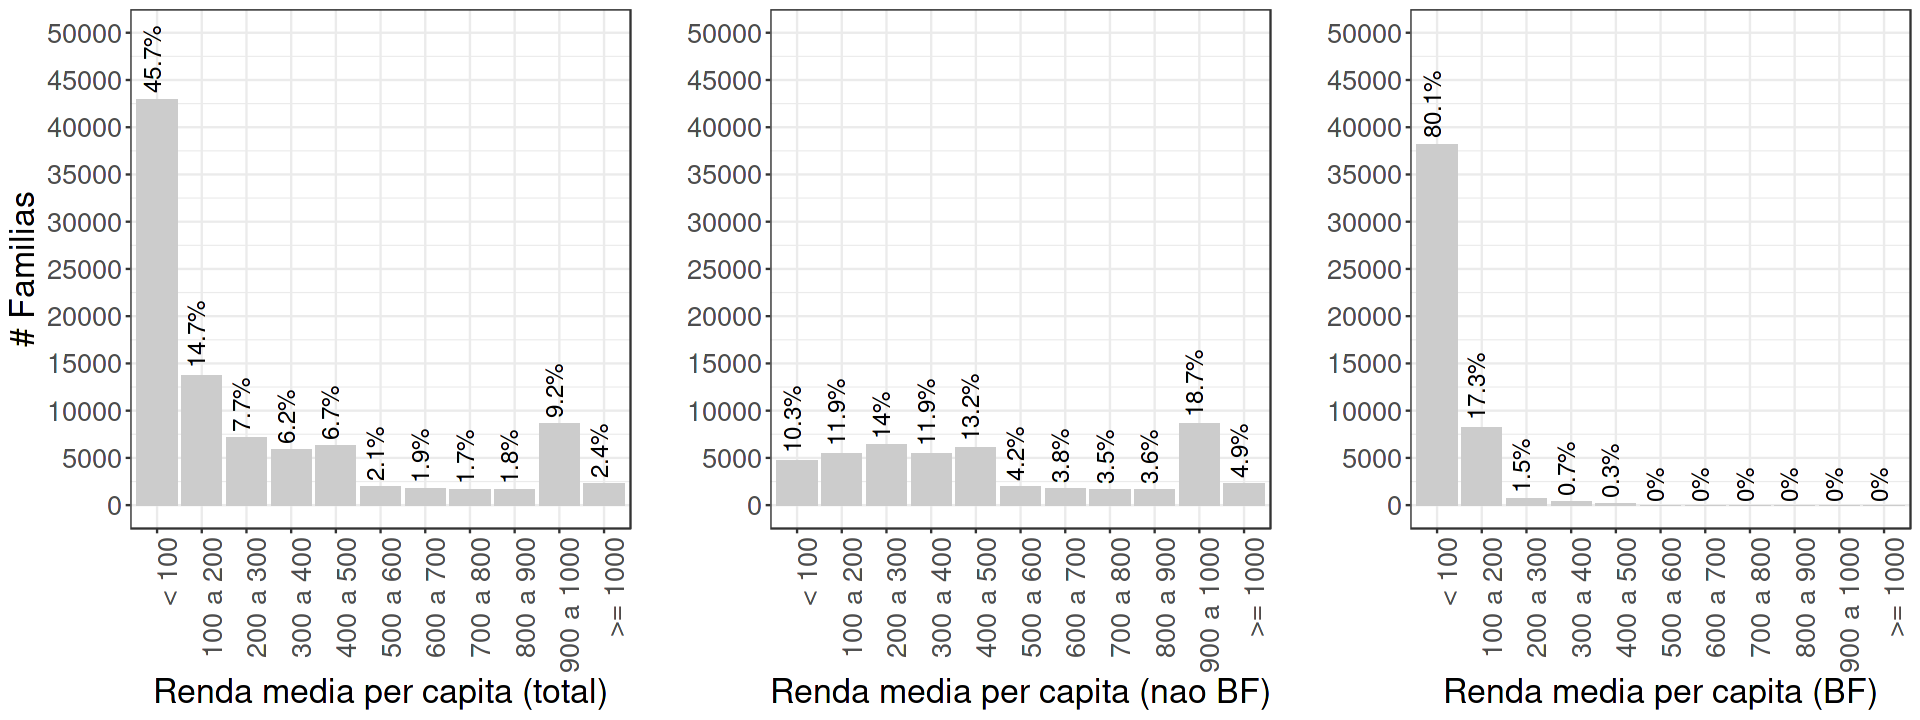

In [791]:
# Define the income intervals. We consider intervals from 0 to 1000 (stepping by 100), and a last interval >= 1000
inter <- seq(0, 1000, by = 100)

freq_renda_all <- rep(0, length(inter))
freq_renda_bf0 <- rep(0, length(inter))
freq_renda_bf1 <- rep(0, length(inter))

for(i in seq(1, length(inter) - 1)) {
    str <- inter[i]
    end <- inter[i+1]
    freq_renda_all[i] <- nrow(df[df$vlr_renda_media_fam >= str & df$vlr_renda_media_fam < end,])
    freq_renda_bf0[i] <- nrow(df[df$marc_pbf == 0 & df$vlr_renda_media_fam >= str & df$vlr_renda_media_fam < end,])
    freq_renda_bf1[i] <- nrow(df[df$marc_pbf == 1 & df$vlr_renda_media_fam >= str & df$vlr_renda_media_fam < end,])
}

freq_renda_all[length(inter)] <- nrow(df[df$vlr_renda_media_fam >= end,])
freq_renda_bf0[length(inter)] <- nrow(df[df$marc_pbf == 0 & df$vlr_renda_media_fam >= end,])
freq_renda_bf1[length(inter)] <- nrow(df[df$marc_pbf == 1 & df$vlr_renda_media_fam >= end,])

perc_renda_all <- 100*round(freq_renda_all/sum(freq_renda_all), 3)
perc_renda_all <- paste(perc_renda_all, '%', sep = '')

perc_renda_bf0 <- 100*round(freq_renda_bf0/sum(freq_renda_bf0), 3)
perc_renda_bf0 <- paste(perc_renda_bf0, '%', sep = '')

perc_renda_bf1 <- 100*round(freq_renda_bf1/sum(freq_renda_bf1), 3)
perc_renda_bf1 <- paste(perc_renda_bf1, '%', sep = '')

intervals <- c('< 100', '100 a 200', '200 a 300', '300 a 400', '400 a 500',
               '500 a 600', '600 a 700', '700 a 800', '800 a 900', '900 a 1000', '>= 1000') 

intervals <- factor(intervals, levels = intervals)

data_histogram_all <- data.frame(salary_range = factor(intervals), freq = freq_renda_all, perc = perc_renda_all)
data_histogram_bf0 <- data.frame(salary_range = factor(intervals), freq = freq_renda_bf0, perc = perc_renda_bf0)
data_histogram_bf1 <- data.frame(salary_range = factor(intervals), freq = freq_renda_bf1, perc = perc_renda_bf1)

max_y <- 50000

plt_renda_all <- ggplot(data_histogram_all, aes(salary_range, freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 5000)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme + 
    ylab("# Familias") +
    xlab("Renda media per capita (total)") +
    geom_text(aes(label = perc_renda_all), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

plt_renda_bf0 <- ggplot(data_histogram_bf0, aes(salary_range, freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 5000)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme + 
    ylab("") +
    xlab("Renda media per capita (nao BF)") +
    geom_text(aes(label = perc_renda_bf0), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

plt_renda_bf1 <- ggplot(data_histogram_bf1, aes(salary_range, freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 5000)) +
    theme_bw() +
    theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
    mytheme + 
    ylab("") +
    xlab("Renda media per capita (BF)") +
    geom_text(aes(label = perc_renda_bf1), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(plt_renda_all, plt_renda_bf0, plt_renda_bf1, ncol = 3)

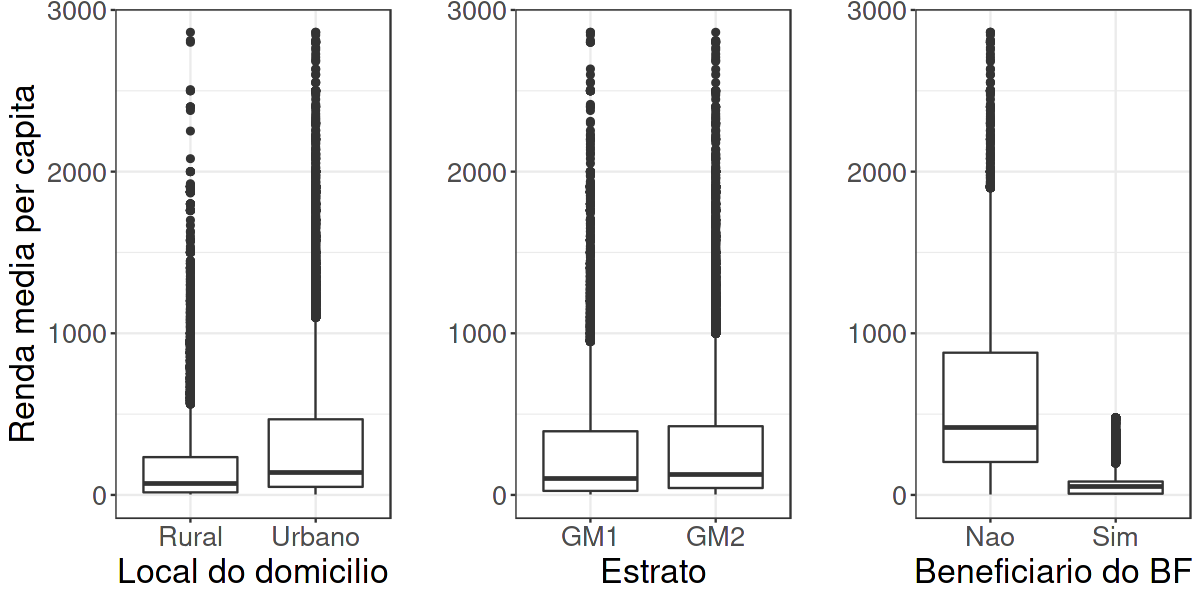

In [795]:
plt_local <- ggplot(df, aes(x = factor(cod_local_domic_fam, levels = 0:1, labels = c('Rural', 'Urbano')),
                            y = vlr_renda_media_fam)) +
    geom_boxplot() +
    theme_bw() + 
    mytheme +
    ylab("Renda media per capita") +
    xlab("Local do domicilio")

plt_estrato <- ggplot(df, aes(x = factor(estrato, levels = 0:1, labels = c('GM1', 'GM2')),
                              y = vlr_renda_media_fam)) +
    geom_boxplot() +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Estrato")

plt_bf <- ggplot(df, aes(x = factor(marc_pbf, levels = 0:1, labels = c('Nao', 'Sim')),
                         y = vlr_renda_media_fam)) +
    geom_boxplot() +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Beneficiario do BF")

options(repr.plot.width = 10, repr.plot.height = 5)
grid.arrange(plt_local, plt_estrato, plt_bf, ncol = 3)

# Family size analysis

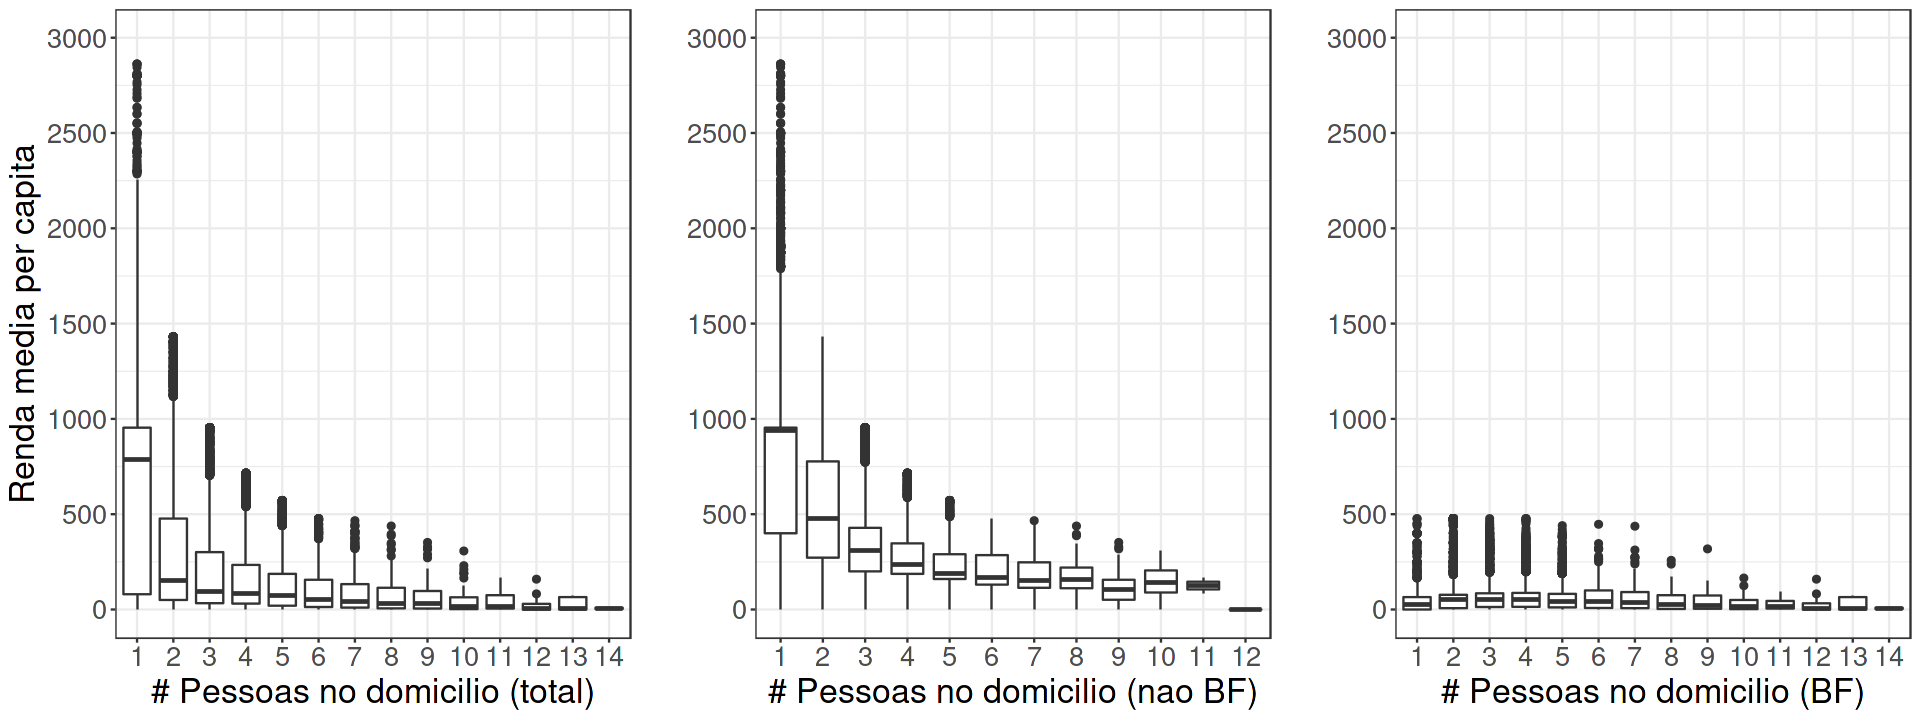

In [792]:
max_y_renda <- 3000

plt_renda_pessoas_all <- ggplot(df, aes(x = factor(qtde_pessoas), y = vlr_renda_media_fam)) +
    geom_boxplot() +
    theme_bw() + 
    mytheme +
    ylab("Renda media per capita") +
    xlab("# Pessoas no domicilio (total)") +
    scale_y_continuous(limits = c(0, max_y_renda), breaks = seq(0, max_y_renda, 500))

plt_renda_pessoas_bf0 <- ggplot(df[df$marc_pbf == 0,], aes(x = factor(qtde_pessoas), y = vlr_renda_media_fam)) +
    geom_boxplot() +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("# Pessoas no domicilio (nao BF)") +
    scale_y_continuous(limits = c(0, max_y_renda), breaks = seq(0, max_y_renda, 500))

plt_renda_pessoas_bf1 <- ggplot(df[df$marc_pbf == 1,], aes(x = factor(qtde_pessoas), y = vlr_renda_media_fam)) +
    geom_boxplot() +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("# Pessoas no domicilio (BF)") +
    scale_y_continuous(limits = c(0, max_y_renda), breaks = seq(0, max_y_renda, 500))

options(repr.plot.width = 16, repr.plot.height = 6)
grid.arrange(plt_renda_pessoas_all, plt_renda_pessoas_bf0, plt_renda_pessoas_bf1, ncol = 3)

In [734]:
df_pessoas_all <- data.frame(table(df$qtde_pessoas))
df_pessoas_bf0 <- data.frame(table(df[df$marc_pbf == 0, ]$qtde_pessoas))
df_pessoas_bf1 <- data.frame(table(df[df$marc_pbf == 1, ]$qtde_pessoas))

perc_pessoas_all <- 100*round(df_pessoas_all$Freq/sum(df_pessoas_all$Freq), 3)
perc_pessoas_all <- paste(perc_pessoas_all, '%', sep = '')

perc_pessoas_bf0 <- 100*round(df_pessoas_bf0$Freq/sum(df_pessoas_bf0$Freq), 3)
perc_pessoas_bf0 <- paste(perc_pessoas_bf0, '%', sep = '')

perc_pessoas_bf1 <- 100*round(df_pessoas_bf1$Freq/sum(df_pessoas_bf1$Freq), 3)
perc_pessoas_bf1 <- paste(perc_pessoas_bf1, '%', sep = '')

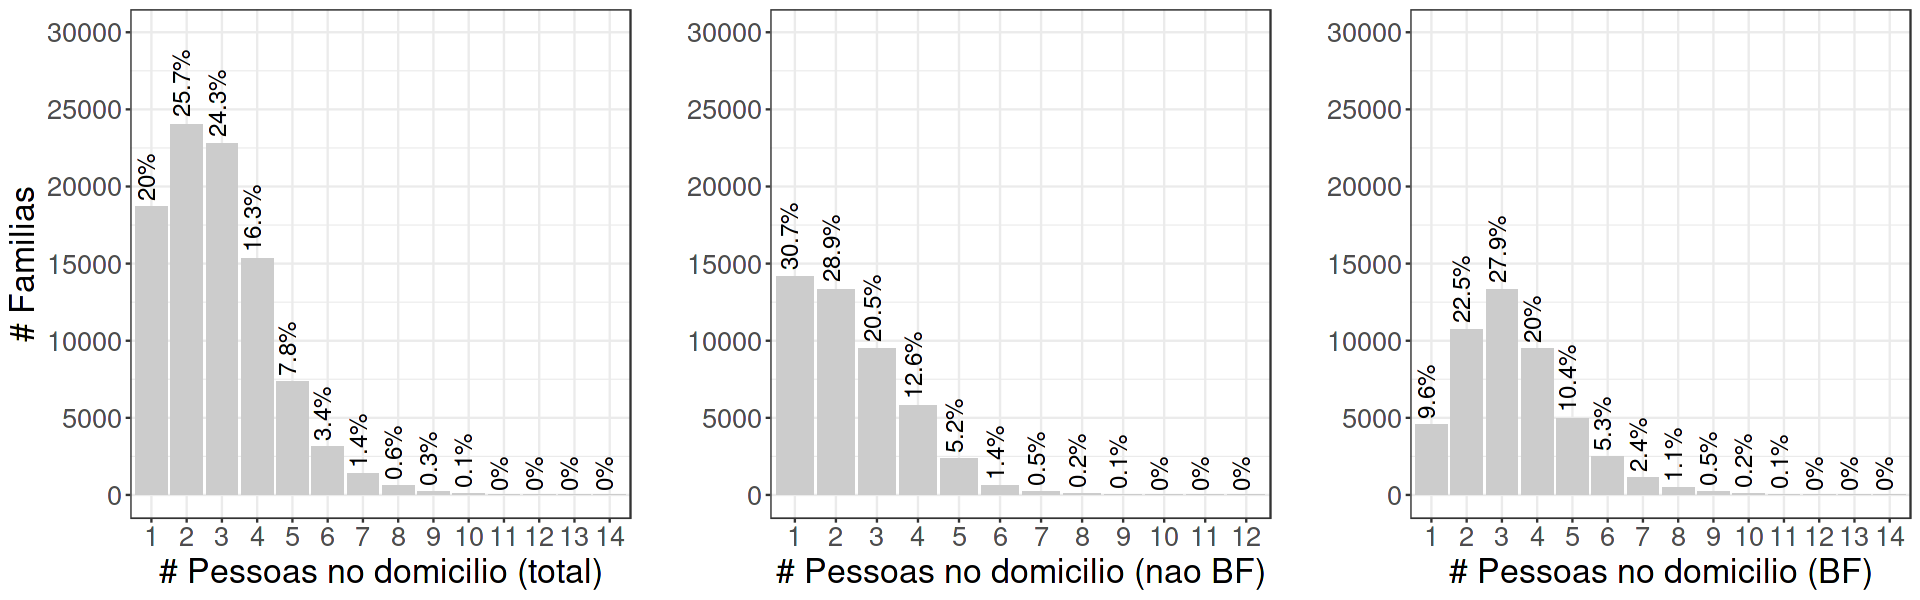

In [788]:
max_y <- 30000

plt_pessoas_all <- ggplot(df_pessoas_all, aes(x = factor(Var1), y = Freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    theme_bw() + 
    mytheme +
    ylab("# Familias") +
    xlab("# Pessoas no domicilio (total)") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 5000)) +
    geom_text(aes(label = perc_pessoas_all), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

plt_pessoas_bf0 <- ggplot(df_pessoas_bf0, aes(x = factor(Var1), y = Freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("# Pessoas no domicilio (nao BF)") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 5000)) +
    geom_text(aes(label = perc_pessoas_bf0), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

plt_pessoas_bf1 <- ggplot(df_pessoas_bf1, aes(x = factor(Var1), y = Freq)) +
    geom_bar(fill = 'grey80', stat = 'identity') +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("# Pessoas no domicilio (BF)") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 5000)) +
    geom_text(aes(label = perc_pessoas_bf1), hjust = -0.1, vjust = 0.2, size = 5, angle = 90)

options(repr.plot.width = 16, repr.plot.height = 5)
grid.arrange(plt_pessoas_all, plt_pessoas_bf0, plt_pessoas_bf1, ncol = 3)

# Home conditions and infra-structure analysis

In [572]:
freq_material_piso <- data.frame(table(df$cod_material_piso_fam))
freq_material_parede <- data.frame(table(df$cod_material_domic_fam))
freq_abastecimento_agua <- data.frame(table(df$cod_abaste_agua_domic_fam))
freq_destino_lixo <- data.frame(table(df$cod_destino_lixo_domic_fam))
freq_iluminacao <- data.frame(table(df$cod_iluminacao_domic_fam))
freq_escoa_sanitario <- data.frame(table(df$cod_escoa_sanitario_domic_fam))

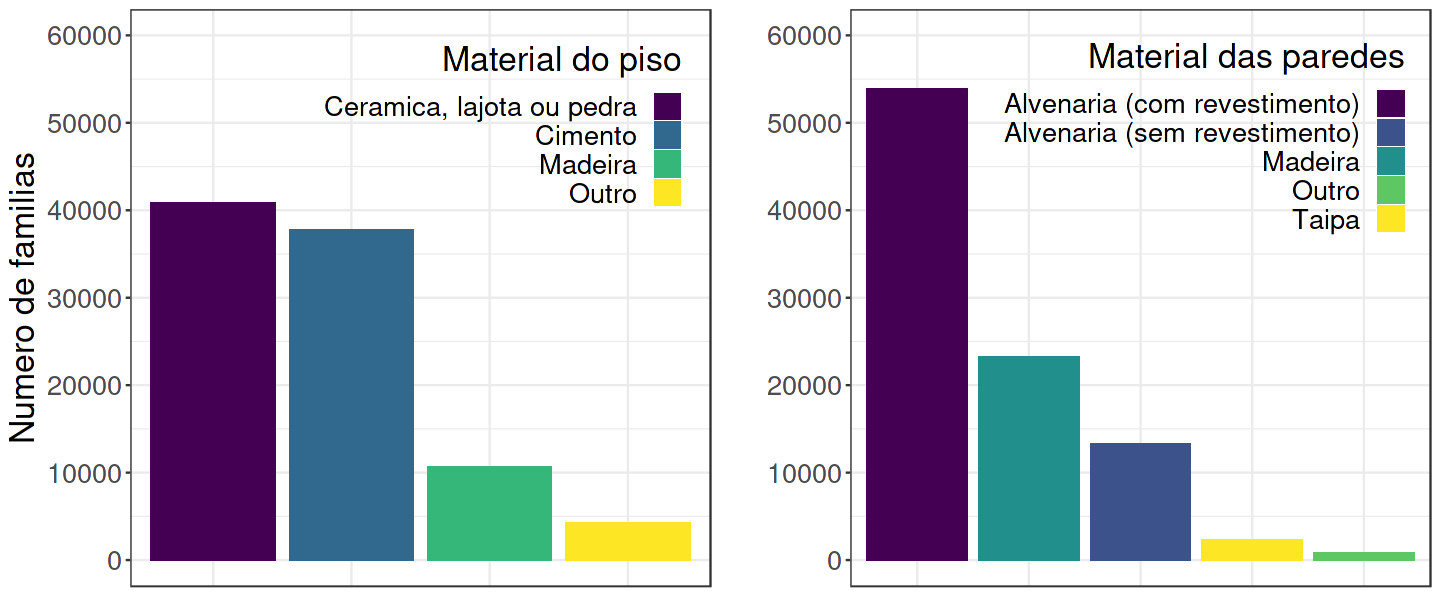

In [573]:
max_y_material <- 60000

plt_material_piso <- ggplot(freq_material_piso, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) + 
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.65, 0.8),
        legend.background = element_rect(fill = "transparent", size = 0.3, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("Numero de familias") +
    labs(fill = "Material do piso") +
    scale_y_continuous(limits = c(0, max_y_material), breaks = seq(0, max_y_material, 10000))

plt_material_parede <- ggplot(freq_material_parede, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) + 
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.62, 0.78),
        legend.background = element_rect(fill = "transparent", size = 0.3, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("") +
    labs(fill = "Material das paredes") +
    scale_y_continuous(limits = c(0, max_y_material), breaks = seq(0, max_y_material, 10000))

options(repr.plot.width = 12, repr.plot.height = 5)
grid.arrange(plt_material_piso, plt_material_parede, ncol = 2)

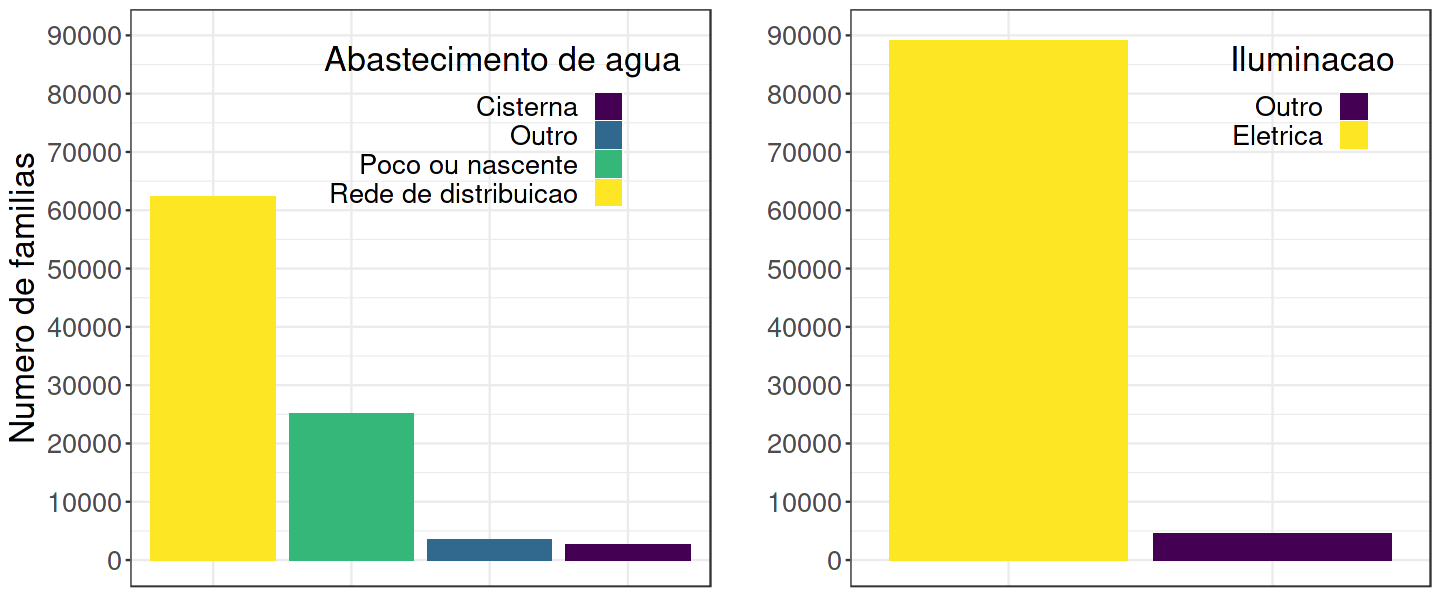

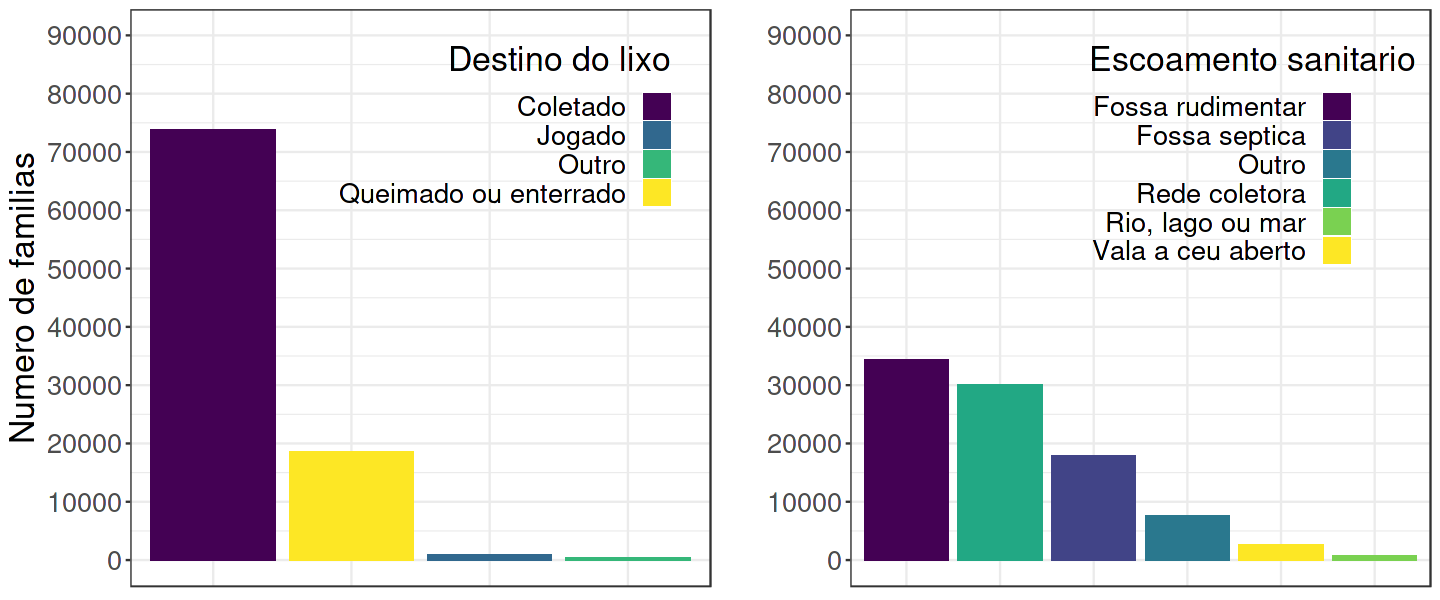

In [574]:
max_y <- 90000

plt_abastecimento_agua <- ggplot(freq_abastecimento_agua, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) + 
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.65, 0.8),
        legend.background = element_rect(fill = "transparent", size = 0.3, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("Numero de familias") +
    labs(fill = "Abastecimento de agua") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 10000))

plt_destino_lixo <- ggplot(freq_destino_lixo, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) + 
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.65, 0.8),
        legend.background = element_rect(fill = "transparent", size = 0.2, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("Numero de familias") +
    labs(fill = "Destino do lixo") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 10000))

plt_iluminacao <- ggplot(freq_iluminacao, aes(
                    x = reorder(Var1, -Freq),
                    y = Freq,
                    fill = factor(Var1, levels = 0:1, labels = c('Outro', 'Eletrica')))) +
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.8, 0.85),
        legend.background = element_rect(fill = "transparent", size = 0.2, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("") +
    labs(fill = "Iluminacao") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 10000))

plt_escoa_sanitario <- ggplot(freq_escoa_sanitario, aes(x = reorder(Var1, -Freq), y = Freq, fill = Var1)) +
    geom_bar(stat = "identity") +
    theme_bw() +
    mytheme +
    theme(axis.title.x = element_blank(),
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        legend.position = c(0.7, 0.75),
        legend.background = element_rect(fill = "transparent", size = 0.2, linetype = "solid")) +
    scale_fill_viridis_d() +
    guides(fill = guide_legend(title.hjust = 1, label.position = "left", label.hjust = 1)) +
    ylab("") +
    labs(fill = "Escoamento sanitario") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 10000))

options(repr.plot.width = 12, repr.plot.height = 5)
grid.arrange(plt_abastecimento_agua, plt_iluminacao, ncol = 2)
grid.arrange(plt_destino_lixo, plt_escoa_sanitario, ncol = 2)

In [728]:
df_agua <- rbind(
    cbind(data.frame(table(df[df$marc_pbf == 0, ]$cod_agua_canalizada_fam)), bf = rep(0, 2)),
    cbind(data.frame(table(df[df$marc_pbf == 1, ]$cod_agua_canalizada_fam)), bf = rep(1, 2))
)
colnames(df_agua) <- c("agua", "freq", "bf")

df_banheiro <- rbind(
    cbind(data.frame(table(df[df$marc_pbf == 0, ]$cod_banheiro_domic_fam)), bf = rep(0, 2)),
    cbind(data.frame(table(df[df$marc_pbf == 1, ]$cod_banheiro_domic_fam)), bf = rep(1, 2))
)
colnames(df_banheiro) <- c("banheiro", "freq", "bf")

df_rede_esg <- rbind(
    cbind(data.frame(table(df[df$marc_pbf == 0, ]$cod_escoa_sanitario_domic_fam == "Rede coletora")), bf = rep(0, 2)),
    cbind(data.frame(table(df[df$marc_pbf == 1, ]$cod_escoa_sanitario_domic_fam == "Rede coletora")), bf = rep(1, 2))
)
colnames(df_rede_esg) <- c("coleta", "freq", "bf")

df_lixo <- rbind(
    cbind(data.frame(table(df[df$marc_pbf == 0, ]$cod_destino_lixo_domic_fam == "Coletado")), bf = rep(0, 2)),
    cbind(data.frame(table(df[df$marc_pbf == 1, ]$cod_destino_lixo_domic_fam == "Coletado")), bf = rep(1, 2))
)
colnames(df_lixo) <- c("coleta", "freq", "bf")

percs_agua <- c(
    100*round(df_agua[df_agua$bf == 0, ]$freq/sum(df_agua[df_agua$bf == 0, ]$freq), 3),
    100*round(df_agua[df_agua$bf == 1, ]$freq/sum(df_agua[df_agua$bf == 1, ]$freq), 3)
)
percs_agua <- paste(percs_agua, '%', sep = '')

percs_banheiro <- c(
    100*round(df_banheiro[df_banheiro$bf == 0, ]$freq/sum(df_banheiro[df_banheiro$bf == 0, ]$freq), 3),
    100*round(df_banheiro[df_banheiro$bf == 1, ]$freq/sum(df_banheiro[df_banheiro$bf == 1, ]$freq), 3)
)
percs_banheiro <- paste(percs_banheiro, '%', sep = '')

percs_rede_esg <- c(
    100*round(df_rede_esg[df_rede_esg$bf == 0, ]$freq/sum(df_rede_esg[df_rede_esg$bf == 0, ]$freq), 3),
    100*round(df_rede_esg[df_rede_esg$bf == 1, ]$freq/sum(df_rede_esg[df_rede_esg$bf == 1, ]$freq), 3)
)
percs_rede_esg <- paste(percs_rede_esg, '%', sep = '')

percs_lixo <- c(
    100*round(df_lixo[df_lixo$bf == 0, ]$freq/sum(df_lixo[df_lixo$bf == 0, ]$freq), 3),
    100*round(df_lixo[df_lixo$bf == 1, ]$freq/sum(df_lixo[df_lixo$bf == 1, ]$freq), 3)
)
percs_lixo <- paste(percs_lixo, '%', sep = '')

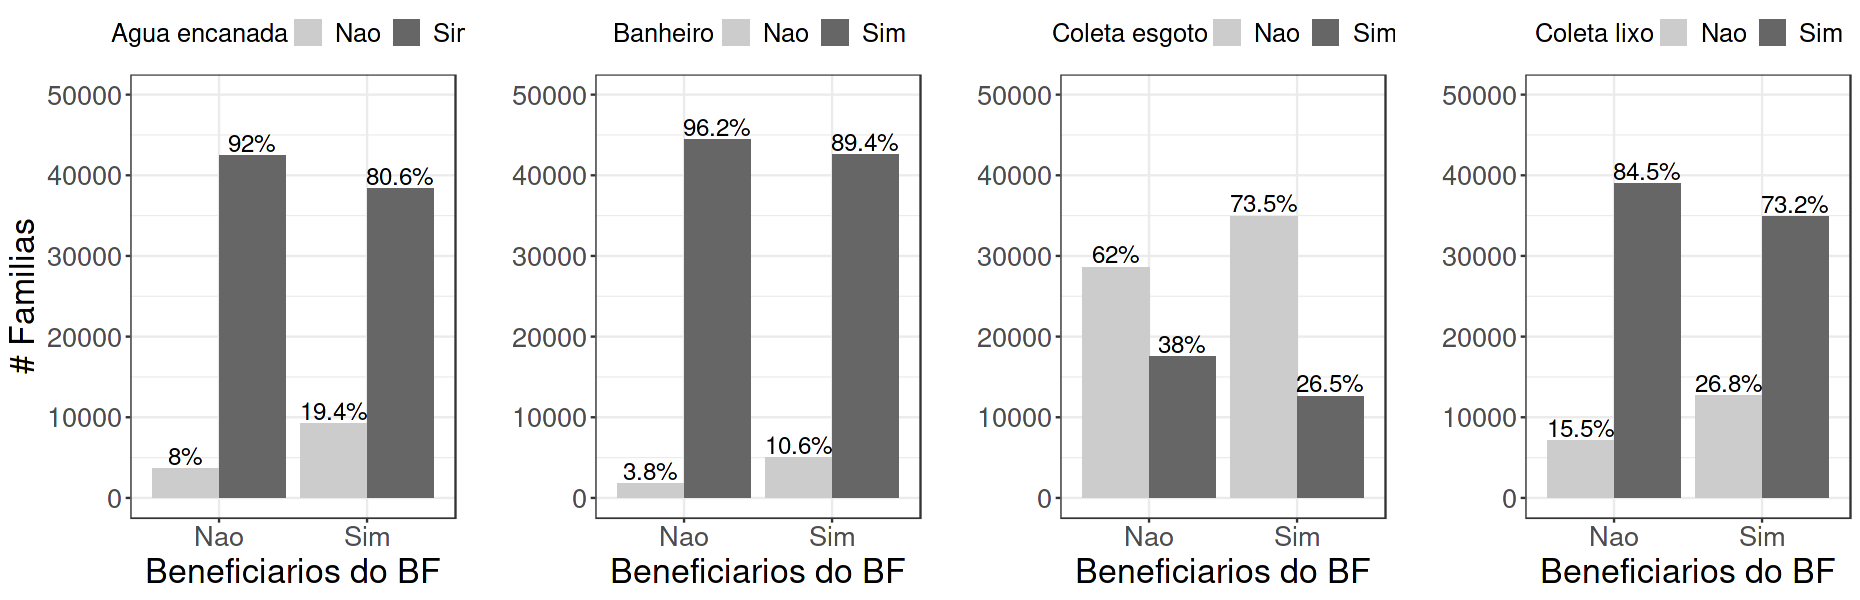

In [732]:
colors <- c("grey80", "grey40")
max_y <- 50000

plt_agua <- ggplot(df_agua, aes(
        x = factor(bf, levels = 0:1, labels = c('Nao', 'Sim')),
        y = freq,
        fill = factor(agua, levels = 0:1, labels = c('Nao', 'Sim')))) +
    geom_bar(position = "dodge", stat = "identity") +
    theme_bw() + 
    mytheme +
    ylab("# Familias") +
    xlab("Beneficiarios do BF") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 10000)) +
    scale_fill_manual(values = colors) +
    geom_text(aes(label = percs_agua), position = position_dodge(width = 0.9), vjust = -0.2, size = 5) +
    labs(fill = "Agua encanada") + 
    theme(legend.position = "top", legend.title = element_text(size = 15), legend.text = element_text(size = 15))

plt_banheiro <- ggplot(df_banheiro, aes(
        x = factor(bf, levels = 0:1, labels = c('Nao', 'Sim')),
        y = freq,
        fill = factor(banheiro, levels = 0:1, labels = c('Nao', 'Sim')))) +
    geom_bar(position = "dodge", stat = "identity") +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Beneficiarios do BF") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 10000)) +
    scale_fill_manual(values = colors) +
    geom_text(aes(label = percs_banheiro), position = position_dodge(width = 0.9), vjust = -0.2, size = 5) +
    labs(fill = "Banheiro") + 
    theme(legend.position = "top", legend.title = element_text(size = 15), legend.text = element_text(size = 15))

plt_rede_esg <- ggplot(df_rede_esg, aes(
        x = factor(bf, levels = 0:1, labels = c('Nao', 'Sim')),
        y = freq,
        fill = factor(coleta, levels = c(FALSE, TRUE), labels = c('Nao', 'Sim')))) +
    geom_bar(position = "dodge", stat = "identity") +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Beneficiarios do BF") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 10000)) +
    scale_fill_manual(values = colors) +
    geom_text(aes(label = percs_rede_esg), position = position_dodge(width = 0.9), vjust = -0.2, size = 5) +
    labs(fill = "Coleta esgoto") + 
    theme(legend.position = "top", legend.title = element_text(size = 15), legend.text = element_text(size = 15))

plt_lixo <- ggplot(df_lixo, aes(
        x = factor(bf, levels = 0:1, labels = c('Nao', 'Sim')),
        y = freq,
        fill = factor(coleta, levels = c(FALSE, TRUE), labels = c('Nao', 'Sim')))) +
    geom_bar(position = "dodge", stat = "identity") +
    theme_bw() + 
    mytheme +
    ylab("") +
    xlab("Beneficiarios do BF") +
    scale_y_continuous(limits = c(0, max_y), breaks = seq(0, max_y, 10000)) +
    scale_fill_manual(values = colors) +
    geom_text(aes(label = percs_lixo), position = position_dodge(width = 0.9), vjust = -0.2, size = 5) +
    labs(fill = "Coleta lixo") + 
    theme(legend.position = "top", legend.title = element_text(size = 15), legend.text = element_text(size = 15))

options(repr.plot.width = 15.5, repr.plot.height = 5)
grid.arrange(plt_agua, plt_banheiro, plt_rede_esg, plt_lixo, ncol = 4)

# Variables correlation

In [576]:
# df_one <- one_hot(as.data.table(df))
dummy <- dummyVars(" ~ .", data = df)
newdata <- data.frame(predict(dummy, newdata = df))

In [577]:
head(newdata)

,estrato,classf,id_familia,vlr_renda_media_fam,cod_local_domic_fam,qtd_comodos_domic_fam,qtd_comodos_dormitorio_fam,cod_material_piso_famCeramica..lajota.ou.pedra,cod_material_piso_famCimento,cod_material_piso_famMadeira,⋯,cod_escoa_sanitario_domic_famVala.a.ceu.aberto,cod_destino_lixo_domic_famColetado,cod_destino_lixo_domic_famJogado,cod_destino_lixo_domic_famOutro,cod_destino_lixo_domic_famQueimado.ou.enterrado,cod_iluminacao_domic_fam,cod_calcamento_domic_fam,indigena_quilombola,marc_pbf,qtde_pessoas
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,2,1,244,1,5,2,1,0,0,⋯,0,1,0,0,0,1,1,0,0,5
2,1,2,3,60,1,5,2,1,0,0,⋯,0,1,0,0,0,1,1,0,1,5
3,1,2,4,937,1,4,1,0,1,0,⋯,0,1,0,0,0,1,0,0,0,1
4,1,2,6,44,1,4,1,0,1,0,⋯,0,1,0,0,0,1,0,0,1,2
5,1,2,7,0,1,4,1,1,0,0,⋯,0,0,0,0,1,1,0,0,1,2
6,1,2,8,176,1,6,3,1,0,0,⋯,0,1,0,0,0,1,1,0,1,5


In [699]:
flattenCorrMatrix <- function(cormat, pmat) {
    M <- ncol(cormat)
    u <- 1
    rows_idx <- rep(0, M*(M-1)/2)
    cols_idx <- rep(0, M*(M-1)/2)
    corr <- rep(0, M*(M-1)/2)
    pval <- rep(0, M*(M-1)/2)
    
    for (i in seq(1, M-1)) {
        for (j in seq(i+1, M)) {
            rows_idx[u] <- i
            cols_idx[u] <- j
            corr[u] <- cormat[i, j]
            pval[u] <- pmat[i, j]
            u <- u+1
        }
    }
    data.frame(
        row = rownames(cormat)[row(cormat)][rows_idx],
        column = rownames(cormat)[row(cormat)][cols_idx],
        cor = corr,
        p = pval
    )
}

In [700]:
set.seed(999)

options(repr.plot.width = 40, repr.plot.height = 40)

cor_features <- cor(newdata[, !(names(newdata) %in% c(
    "id_familia"
))])

col <- colorRampPalette(c("#BB4444", "#EE9988", "#FFFFFF", "#77AADD", "#4477AA"))

# img_cor <- corrplot(cor_features, method = "color", col = col(200), mar = c(0, 0, 0, 0),  
#          #type = "upper",
#          order = "hclust", 
#          addCoef.col = "black",
#          tl.col = "black",
#          tl.srt = 90,
#          diag = FALSE
# )

# correlation <- cor(newdata[, !(names(newdata) %in% c("id_familia"))])
# res <- rcorr(as.matrix(newdata[, c('marc_pbf', 'vlr_renda_media_fam', 'cod_local_domic_fam')]))
res <- rcorr(as.matrix(newdata[, !(names(newdata) %in% c("id_familia"))]))
df_cor <- flattenCorrMatrix(res$r, res$P)

df_cor[order(-df_cor$cor),][1:20,]
df_cor[order(df_cor$cor),][1:20,]
# img_cor

,row,column,cor,p
,<fct>,<fct>,<dbl>,<dbl>
126,cod_local_domic_fam,cod_destino_lixo_domic_famColetado,0.7333555,0
135,qtd_comodos_domic_fam,qtd_comodos_dormitorio_fam,0.6796740,0
46,classf,cod_material_domic_famMadeira,0.6113291,0
256,cod_material_piso_famMadeira,cod_material_domic_famMadeira,0.5758385,0
502,cod_abaste_agua_domic_famRede.de.distribuicao,cod_destino_lixo_domic_famColetado,0.5425929,0
118,cod_local_domic_fam,cod_abaste_agua_domic_famRede.de.distribuicao,0.5404307,0
599,cod_destino_lixo_domic_famColetado,cod_calcamento_domic_fam,0.5106248,0
131,cod_local_domic_fam,cod_calcamento_domic_fam,0.5004141,0
489,cod_abaste_agua_domic_famPoco.ou.nascente,cod_destino_lixo_domic_famQueimado.ou.enterrado,0.4865727,0


,row,column,cor,p
,<fct>,<fct>,<dbl>,<dbl>
597,cod_destino_lixo_domic_famColetado,cod_destino_lixo_domic_famQueimado.ou.enterrado,-0.9565523,0
513,cod_banheiro_domic_fam,cod_escoa_sanitario_domic_famOutro,-0.9374684,0
478,cod_abaste_agua_domic_famPoco.ou.nascente,cod_abaste_agua_domic_famRede.de.distribuicao,-0.8528297,0
129,cod_local_domic_fam,cod_destino_lixo_domic_famQueimado.ou.enterrado,-0.7257441,0
196,cod_material_piso_famCeramica..lajota.ou.pedra,cod_material_piso_famCimento,-0.7234128,0
307,cod_material_domic_famAlvenaria..com.revestimento.,cod_material_domic_famMadeira,-0.6674167,0
101,vlr_renda_media_fam,marc_pbf,-0.6392571,0
505,cod_abaste_agua_domic_famRede.de.distribuicao,cod_destino_lixo_domic_famQueimado.ou.enterrado,-0.5329262,0
528,cod_escoa_sanitario_domic_famFossa.rudimentar,cod_escoa_sanitario_domic_famRede.coletora,-0.5244704,0
